## Tracking evolution of several stats (mean, median, std) over range of PCs

In [1]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.decomposition import PCA
from importlib import reload
from numpy import linalg as LA
from scipy.stats import ks_2samp
import rutils
from pyaldata import *
from rutils import *
np.set_printoptions(precision=3)

'''
Plotting aesthetics
'''
sns.set_style('white')
sns.set_context('notebook', font_scale=1.35)

cmap = sns.light_palette(color='#183D51', as_cmap=True)
div_cmap = sns.diverging_palette(250, 150, as_cmap=True)

cs = ['#732514', '#FEB312', '#233A6A', '#545340', '#4E81AF', '#183D51']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)
np.set_printoptions(suppress=True)

'''
Magic commands
'''
%config InlineBackend.figure_format = 'retina'

## 0 Load data

In [2]:
file = 'Chewie_CO_VR_2016-09-09.mat'  # file matt used to generate initial figures in matlab

#file = 'Chewie_CO_FF_2016-10-07.mat' # other one matt used

#file = 'Chewie_CO_FF_2016-09-21.mat' # my initial file

#file = 'Chewie_CO_VR_2016-10-06.mat' # other file

path = '/Users/Daphne/Data/'
df = mat2dataframe(path+file, shift_idx_fields=True)

## 1a. Preprocess

In [234]:
# Combine bins 
td = combine_time_bins(df, n_bins=3)

# Remove low firing neurons
td = remove_low_firing_neurons(td, signal='M1_spikes',  threshold=0)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=0)

# Sqrt transform neurons
td = transform_signal(td, signals='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signals='PMd_spikes', transformations='sqrt')

# Merge signals
td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

# Calculate firing rates from spikes, works on '_spikes' fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth', std=0.05)

# # Select only baseline (BL) trials
# td = td.loc[td['epoch'] == 'BL']

print(f'Total neurons before processing: {df.M1_spikes[0].shape[1]+ df.PMd_spikes[0].shape[1]}\n')
print(f'Total neurons after preprocessing: {td.M1_spikes[0].shape[1]+ td.PMd_spikes[0].shape[1]} ({td.M1_spikes[0].shape[1]} M1 neurons and {td.PMd_spikes[0].shape[1]} PMd neurons)')

Total neurons before processing: 246

Total neurons after preprocessing: 246 (55 M1 neurons and 191 PMd neurons)


## 1b. Weight PC matrix by occurrences 

We have more samples from some locations than from others. To correct for the uneven collection of neural spike patterns we can apply a kind of weighting before doing PCA. This involves scaling the firing rates in $\mathbf{X}$ up or down based on the number of times we have samples from the same location (i.e. number of neurons from the same electrode).

- If we have many neurons from the same electrode, increase the weight
- If we have few neurons from the same electrode, decrease the weight

[...]

<img src="https://drive.google.com/uc?export=view&id=1ecqjQ8rALrjJ-4817JJLfk-EBkh8JtIA" style="width: 400px; max-width: 100%; height: auto"/>

### 2 Perform PCA on both arrays
---

> `.components_` returns a matrix of size `(n_components, n_features)` (this is $\mathbf{U}$)
   - Each row is a principal component and each column is a neuron (feature)
   - These are the eigenvectors, they provide a basis for the neural space ($\mathbf{U}$ is orthonormal)
    

In [24]:
td.both_rates[0].shape

(98, 246)

We perform trial-concatenated PCA, which produces a separate set of temporal factors for each trial. Concretely, let $\mathbf{X}$ be our data matrix of size _N_ $\times$ _T_ ()

\begin{align}
    \mathbf{X} = \mathbf{W} \mathbf{B}^\top 
\end{align}

where

- $\mathbf{W}$ is the _N_ $\times$ _N_ matrix with as columns the neuron factors
- $\mathbf{B}$ is the _T_ $\times$ _T_ matrix with as columns the temporal factors (we have a set of these for each trial)


In [25]:
# We want to get a PC for all neurons
pca_dims = td.both_rates[0].shape[1]

# Perform dimensionality reduction on all trialdata
# This function concatenates the data by trials over time and performs the dimensionality reduction on that 2d matrix
td, model_m1pmd = tools.dim_reduce(td, PCA(pca_dims), 'both_rates', 'both_pca', return_model=True)

In [242]:
pca_dims

246

In [243]:
# So this is the size of the matrix on which we perform PCA
np.concatenate(td['both_rates'].values, axis=0).shape

(114364, 246)

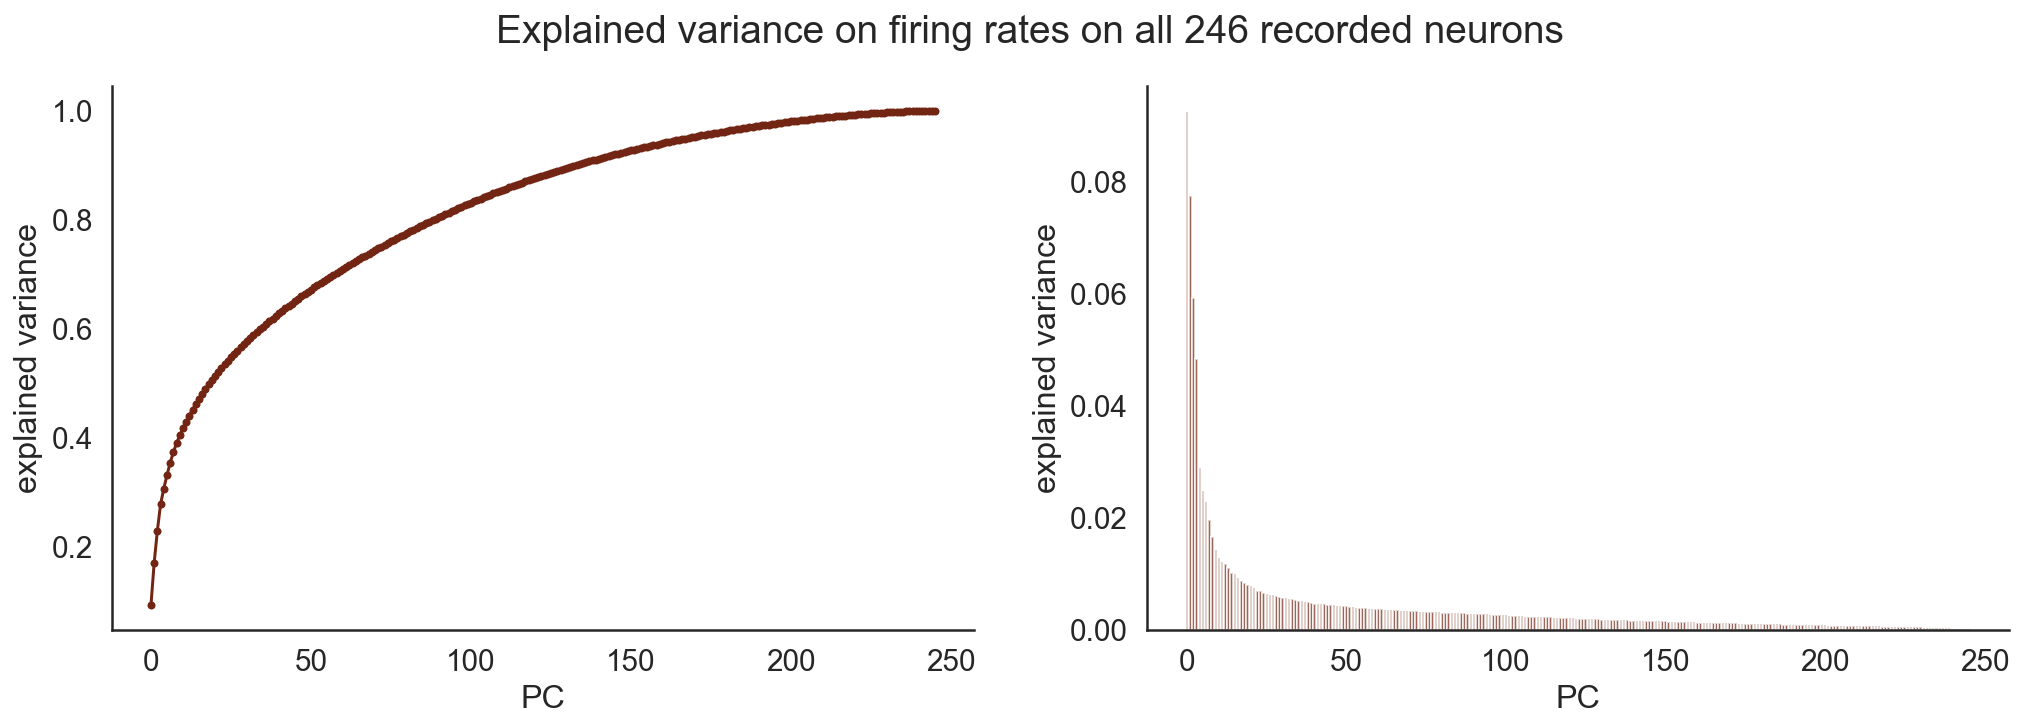

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
fig.suptitle(f'Explained variance on firing rates on all {td.both_rates[0].shape[1]} recorded neurons')
ax1.plot(model_m1pmd.explained_variance_ratio_.cumsum(), '.-')
ax1.set_xlabel('PC')
ax1.set_ylabel('explained variance')

ax2.bar(range(len(model_m1pmd.explained_variance_ratio_)), model_m1pmd.explained_variance_ratio_, alpha=0.7, align='center')
ax2.set_xlabel('PC')
ax2.set_ylabel('explained variance')
sns.despine()

In [27]:
'''
Get the principal components
'''

m1pmd_pcs = model_m1pmd.components_.T

In [28]:
# Read in cmp file and get electrode map
m1_elecmap  = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left M1 SN 6250-001474.cmp'), elecs=range(1,97))
pmd_elecmap = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left PMd SN 6251-001469.cmp'), elecs=range(1,97))

### More PCs!

Let $\mathbf{M}$ be our PC matrix in the form $N \times N$. Here, every _row_ represents a neuron and every _column_ a principal component. 

\begin{align}
\mathbf{M} = 
\begin{bmatrix} 
| & | &  & | \\
 \text{pc}_1 & \text{pc}_2 & \dots & \text{pc}_N \\
| & | & & | \\
\end{bmatrix}
\end{align}

We take the first _r_ PCs (columns) of $\mathbf{M}$, which yields a $N \times r$ matrix.

\begin{align}
\mathbf{M}' = 
\begin{bmatrix} 
| & | & | \\
 \text{pc}_1 & \text{pc}_2 & \text{pc}_r \\
| & | & | \\
\end{bmatrix}
\end{align}

For example, the first row is $\mathbf{v}_{\text{n}_1}$. We compare the rows by taking the euclidean distance between each two pairs of neurons. For neuron 1 and 2 this becomes

\begin{align}
    \| \mathbf{v}_{\text{n}_1} - \mathbf{v}_{\text{n}_2} \|_2^2
\end{align}

To be explicit, we are talking about two types of _distances_:

- Spatial distance, $\mathbf{S}_{\text{dist}}$, is the anatomical distance between neurons in the brain. 
- Weight distance, $\mathbf{W}_{\text{dist}}$, is the distance or difference in the principal component weights.

<img src="https://drive.google.com/uc?export=view&id=10XUIunGfS8xCLkptEWjxJ5ABHFnEpr-9" style="width: 500px; max-width: 100%; height: auto"/>


In [9]:
def compare_r_pcs(pcs, r, m1_emap, m1_unitguide, pmd_emap, pmd_unitguide):
    '''
    Compute the distance of the first r principal components between each combination of neurons.
    
    Parameters
    ----------
    pcs: np.array
        principal components
    r: int
        the number of principal components (cols) to compare
    '''
    # Compare neurons within M1 
    n_m1 = m1_unitguide.shape[0] # Number of neurons on M1 array
    M_m1 = pcs[0:n_m1, :r] # Take the first r columns of the principal components matrix (on M1 array)
    # Don't care where the neuron comes from (2d-array), 
    # we only want to know how spaial distance and weight distance relate (1d-array)
    m1_within_S_dist, m1_within_W_dist = [], []
    
    for i in range(n_m1): 
        
        elec_i = m1_unitguide[i, 0] # Neuron i is on this electrode
        loc_i  = np.array(np.where(m1_emap == elec_i)) # location of electrode on array
        
        # Compare this neuron's weights (row) to all other neurons within array (j != i)
        for j in range(i+1, n_m1):
            
            elec_j = m1_unitguide[j, 0] # Neuron j is on this electrode
            loc_j  = np.array(np.where(m1_emap == elec_j))

            # Compute spatial distance between two neurons on array
            m1_within_S_dist.append(LA.norm(loc_i - loc_j))

            # Compute PC weight distance between the neurons on array
            m1_within_W_dist.append(LA.norm(M_m1[i, :] - M_m1[j, :]))
        
    # Compare neurons within PMd
    n_pmd = pmd_unitguide.shape[0] # Number of neurons on PMd array
    M_pmd = pcs[n_m1:, :r] 
    pmd_within_S_dist, pmd_within_W_dist = [], []    
    
    for i in range(n_pmd):
        
        elec_i = pmd_unitguide[i, 0] # Neuron i is on this electrode
        loc_i  = np.array(np.where(pmd_emap == elec_i)) # location of electrode on array

        # Compare this neuron's weights (row) to all other neurons within array (j != i)
        for j in range(i+1, n_pmd):

            elec_j = pmd_unitguide[j, 0] # Neuron j is on this electrode
            loc_j  = np.array(np.where(pmd_emap == elec_j))

            # Compute spatial distance between two neurons on array
            pmd_within_S_dist.append(LA.norm(loc_i - loc_j))

            # Compute PC weight distance between the neurons on array
            pmd_within_W_dist.append(LA.norm(M_pmd[i, :] - M_pmd[j, :]))
            
    # Compare neurons between M1 and PMd
    between_W_dist = []
    
    for i in range(n_pmd):
        for j in range(n_m1):
            between_W_dist.append(LA.norm(M_pmd[i, :] - M_m1[j, :]))
            
    return np.array(m1_within_S_dist), np.array(m1_within_W_dist), np.array(pmd_within_S_dist), np.array(pmd_within_W_dist), np.array(between_W_dist)

### 3.1 Use the spatial distance to sort the weight distances of _r_ PCs

One way to find out whether there is a relationship between physical location and distance in the principal component ways is to compute the weight distances with _r_ PCs and then sort them based on spatial distance. 


In [29]:
'''
Choose the number of PCs to use (r) and compute the distances 
'''
r = 10

S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd, W_dist_between = compare_r_pcs(pcs=m1pmd_pcs, r=r, m1_emap=m1_elecmap, 
                                                                             m1_unitguide=td['M1_unit_guide'][0], pmd_emap=pmd_elecmap, pmd_unitguide=td['PMd_unit_guide'][0])

In [30]:
S_dist_m1.shape, S_dist_pmd.shape, W_dist_between.shape # Sanity check: are in line with computed number of combinations

((1485,), (18145,), (10505,))

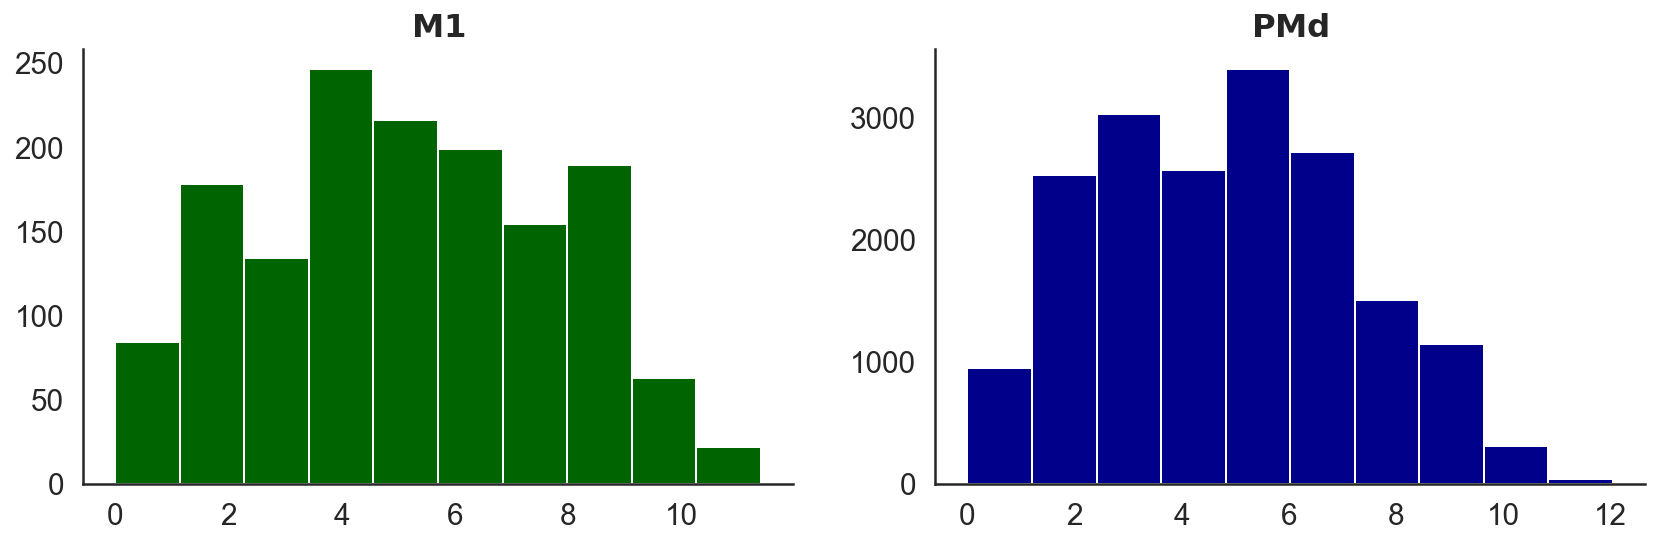

In [31]:
# Sanity check: distribution of distances
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
axs[0].set_title(r'$\bf{M1}$')
axs[0].hist(S_dist_m1, color='darkgreen')

axs[1].set_title(r'$\bf{PMd}$')
axs[1].hist(S_dist_pmd, color='darkblue')
sns.despine()

This does not seem to do a lot... 

Perhaps check if something went wrong with sorting.

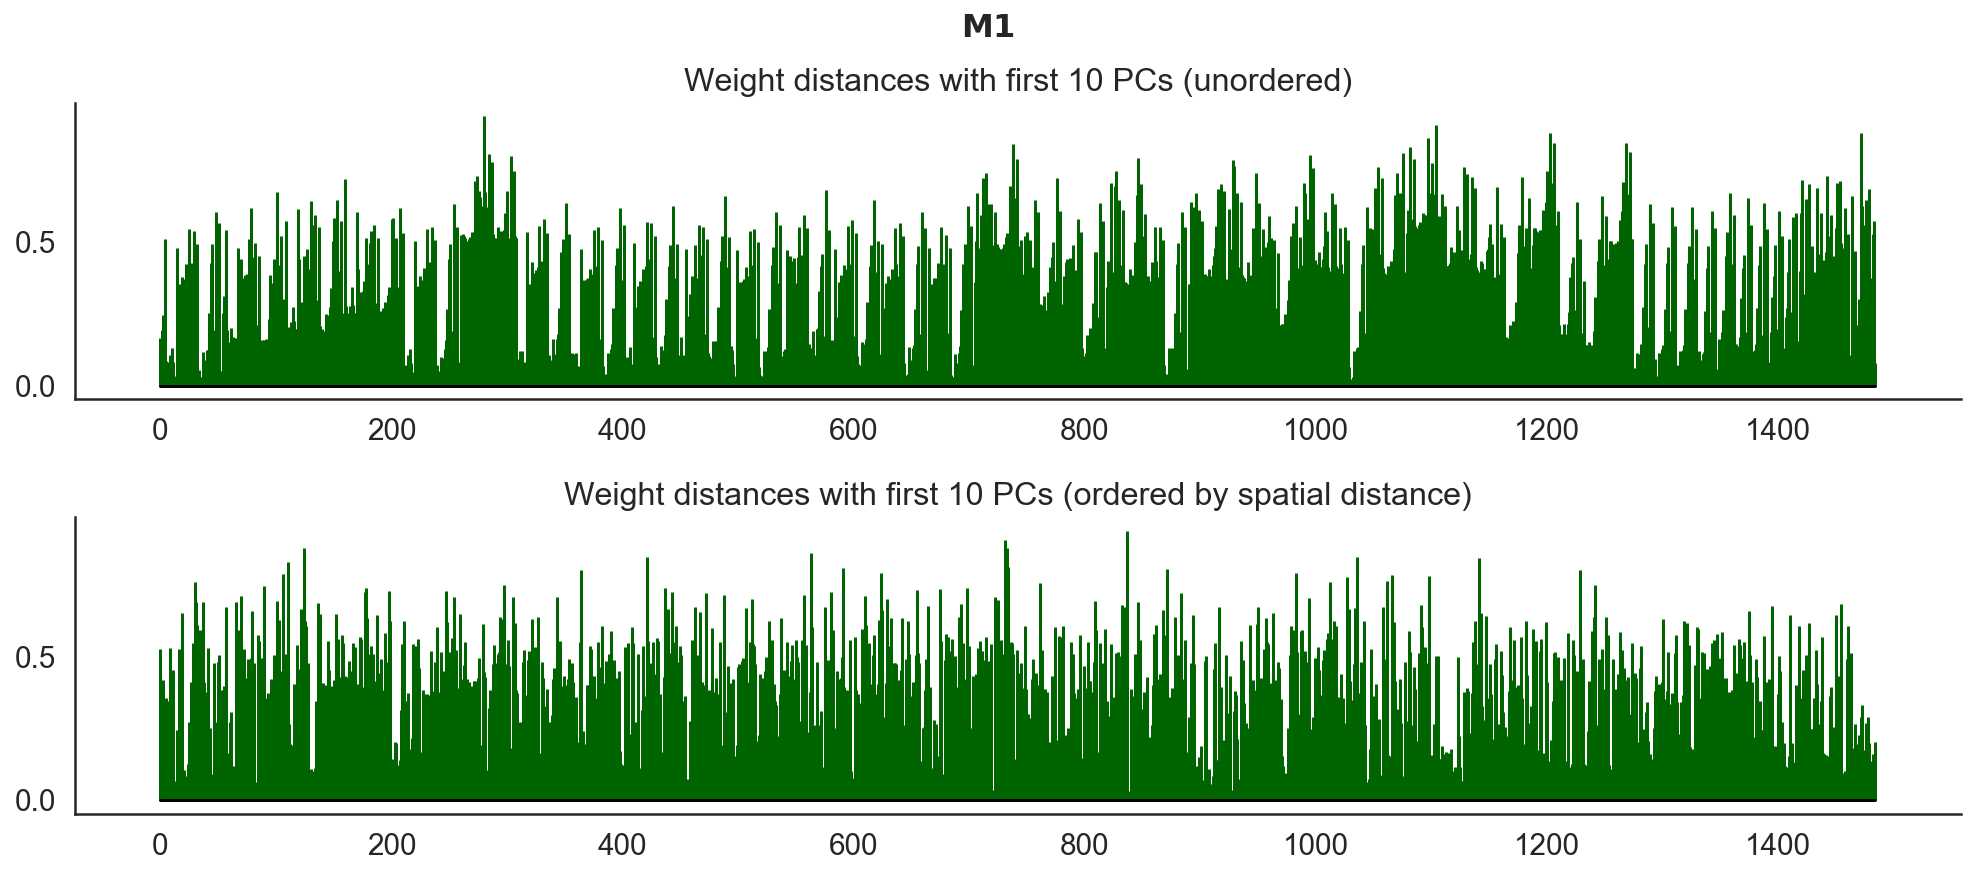

In [32]:
# Sort by spatial distance within array (indices)
mask_m1 = np.argsort(S_dist_m1)

# Compare distributions
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))
fig.suptitle(r'$\bf{M1}$', y=1.02, fontasize=16)
axs[0].set_title(f'Weight distances with first {r} PCs (unordered)')
axs[0].stem(np.arange(len(W_dist_m1)), W_dist_m1, basefmt='k-', markerfmt=' ', linefmt='darkgreen', use_line_collection=True)

axs[1].set_title(f'Weight distances with first {r} PCs (ordered by spatial distance)')
axs[1].stem(np.arange(len(W_dist_m1)), W_dist_m1[mask_m1], basefmt='k-', markerfmt=' ', linefmt='darkgreen', use_line_collection=True)
sns.despine(), plt.tight_layout();

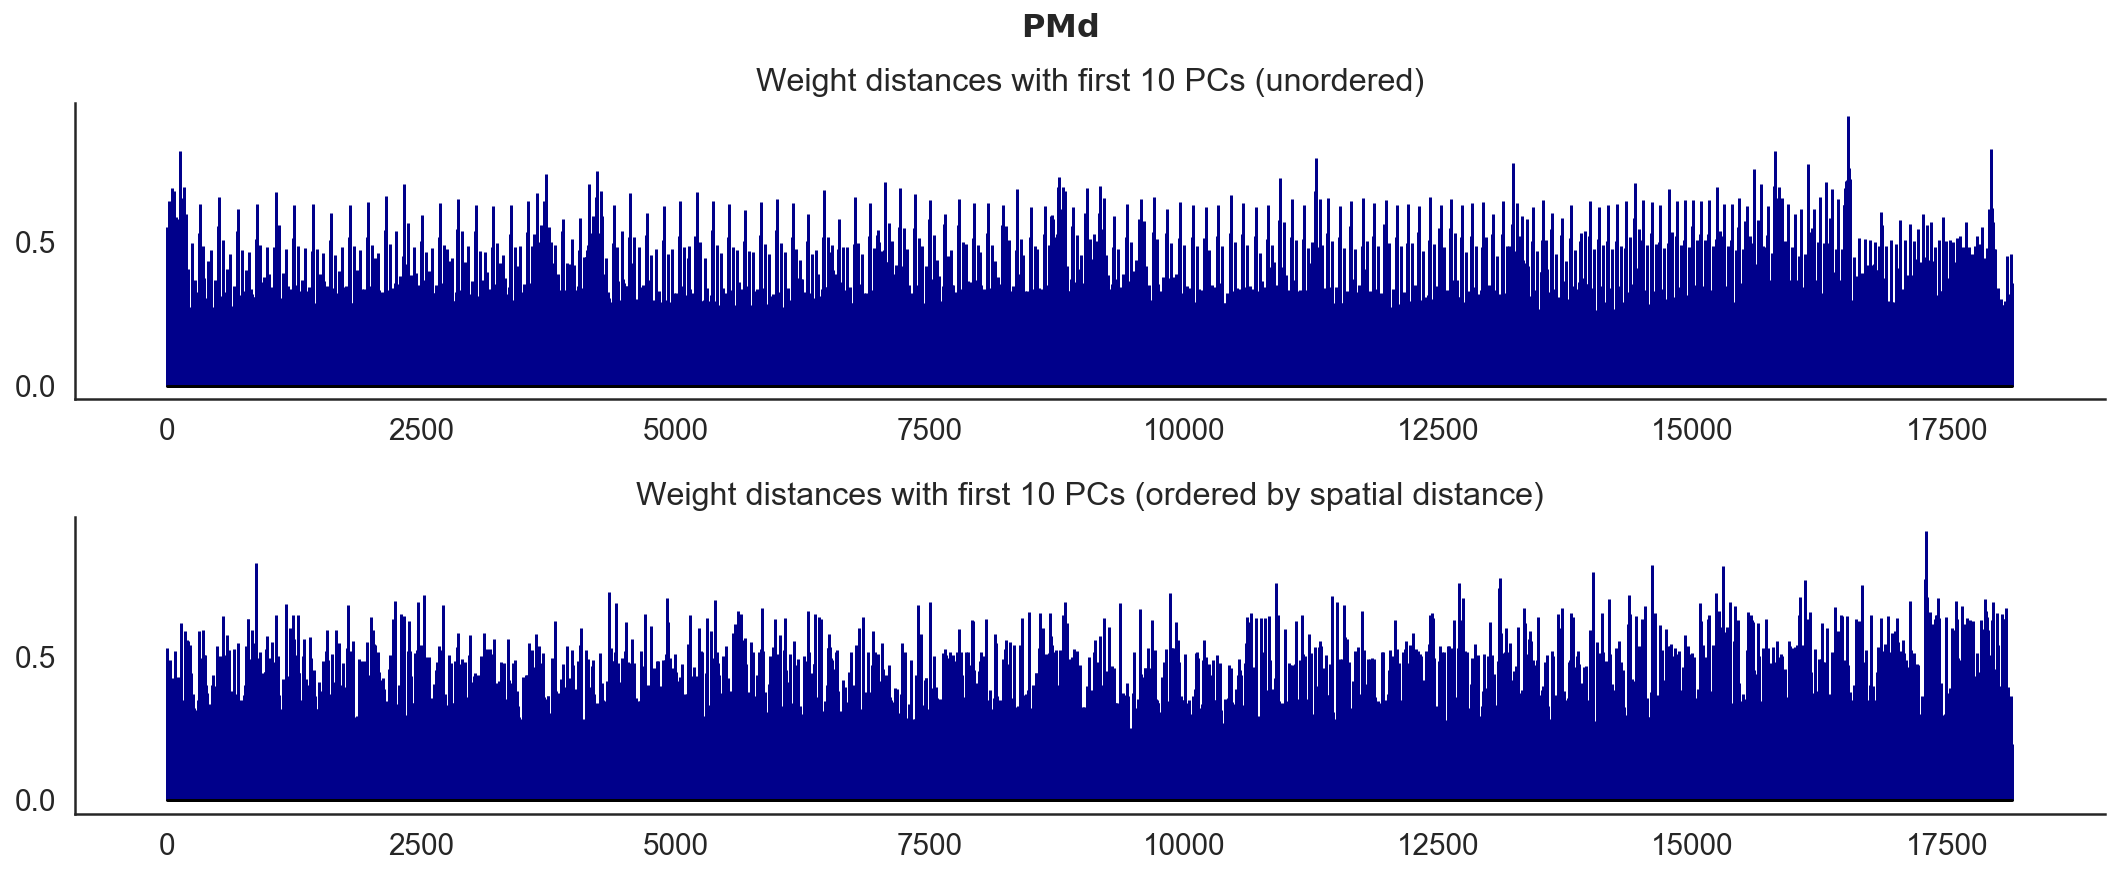

In [33]:
# Sort by spatial distance within array (indices)
mask_pmd = np.argsort(S_dist_pmd)

# Compare distributions
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
fig.suptitle(r'$\bf{PMd}$', y=1.02, fontsize=16)

axs[0].set_title(f'Weight distances with first {r} PCs (unordered)')
axs[0].stem(np.arange(len(W_dist_pmd)), W_dist_pmd, basefmt='k-', markerfmt=' ', linefmt='darkblue', use_line_collection=True)

axs[1].set_title(f'Weight distances with first {r} PCs (ordered by spatial distance)')
axs[1].stem(np.arange(len(W_dist_pmd)), W_dist_pmd[mask_pmd], basefmt='k-', markerfmt=' ', linefmt='darkblue', use_line_collection=True)
sns.despine(), plt.tight_layout();

### 3.2 Create categories based on spatial distances 

---

We divide the weight distances in 3 main categories based on the distances from each other: 
- Same electrode ($s_{dist} = 0$)
- Same array ($0 < s_{dist} < 11$)
- Other array ($s_{dist} > 11$) 

Remember that we are interested in whether there are any significant differences in the weights between these groups. Essentially:

> Are there any noticeable differences in the distributions of the 3 groups?

We look at the following 

- The distributions (diffusion).
- The **mean weight** distance (we expect an inverse relationship between distance and weight difference, which implies that the average distance in the category _other array_ is larger than in the categories _same electrode_ and _same array_).
    - In the same line of reasoning, the largest weight differences should be between the groups _other array_ and _same array, same elec_.
- The **median weight** distance
- The **standard deviation**
- The violinplot that shows a kernel density estimation of the underlying distribution.



In [34]:
def make_groups(S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd):
    '''Group weight distances of the neurons based on spatial distance in the brain.'''

    # First we merge the spatial distances obtained from the M1 and PMd arrays
    S_dist_both = np.concatenate((S_dist_m1, S_dist_pmd))

    # Then we merge the weight distances obtained from both arrays
    W_dist_both = np.concatenate((W_dist_m1, W_dist_pmd))

    # Now we can make groups based on distance
    same_elec_idx  = np.where(S_dist_both == 0) # Zero distance
    same_array_idx = np.where(S_dist_both != 0) # On the same array

    # Use the indices to group the weight distances
    W_dist_se = W_dist_both[same_elec_idx]
    W_dist_sa = W_dist_both[same_array_idx]
    
    return S_dist_both, W_dist_se, W_dist_sa

In [35]:
'''
Choose r PCs, compute distances and compare
'''
r = 10 
 
# Compute the spatial and weight distances with the first r PCs
S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd, W_dist_oa = compare_r_pcs(pcs=m1pmd_pcs, r=r, m1_emap=m1_elecmap, m1_unitguide=td['M1_unit_guide'][0], 
                                                                        pmd_emap=pmd_elecmap, pmd_unitguide=td['PMd_unit_guide'][0])
# Make groups within array based on spatial distance (same elec, same array)
S_dist_both , W_dist_se, W_dist_sa = make_groups(S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd)

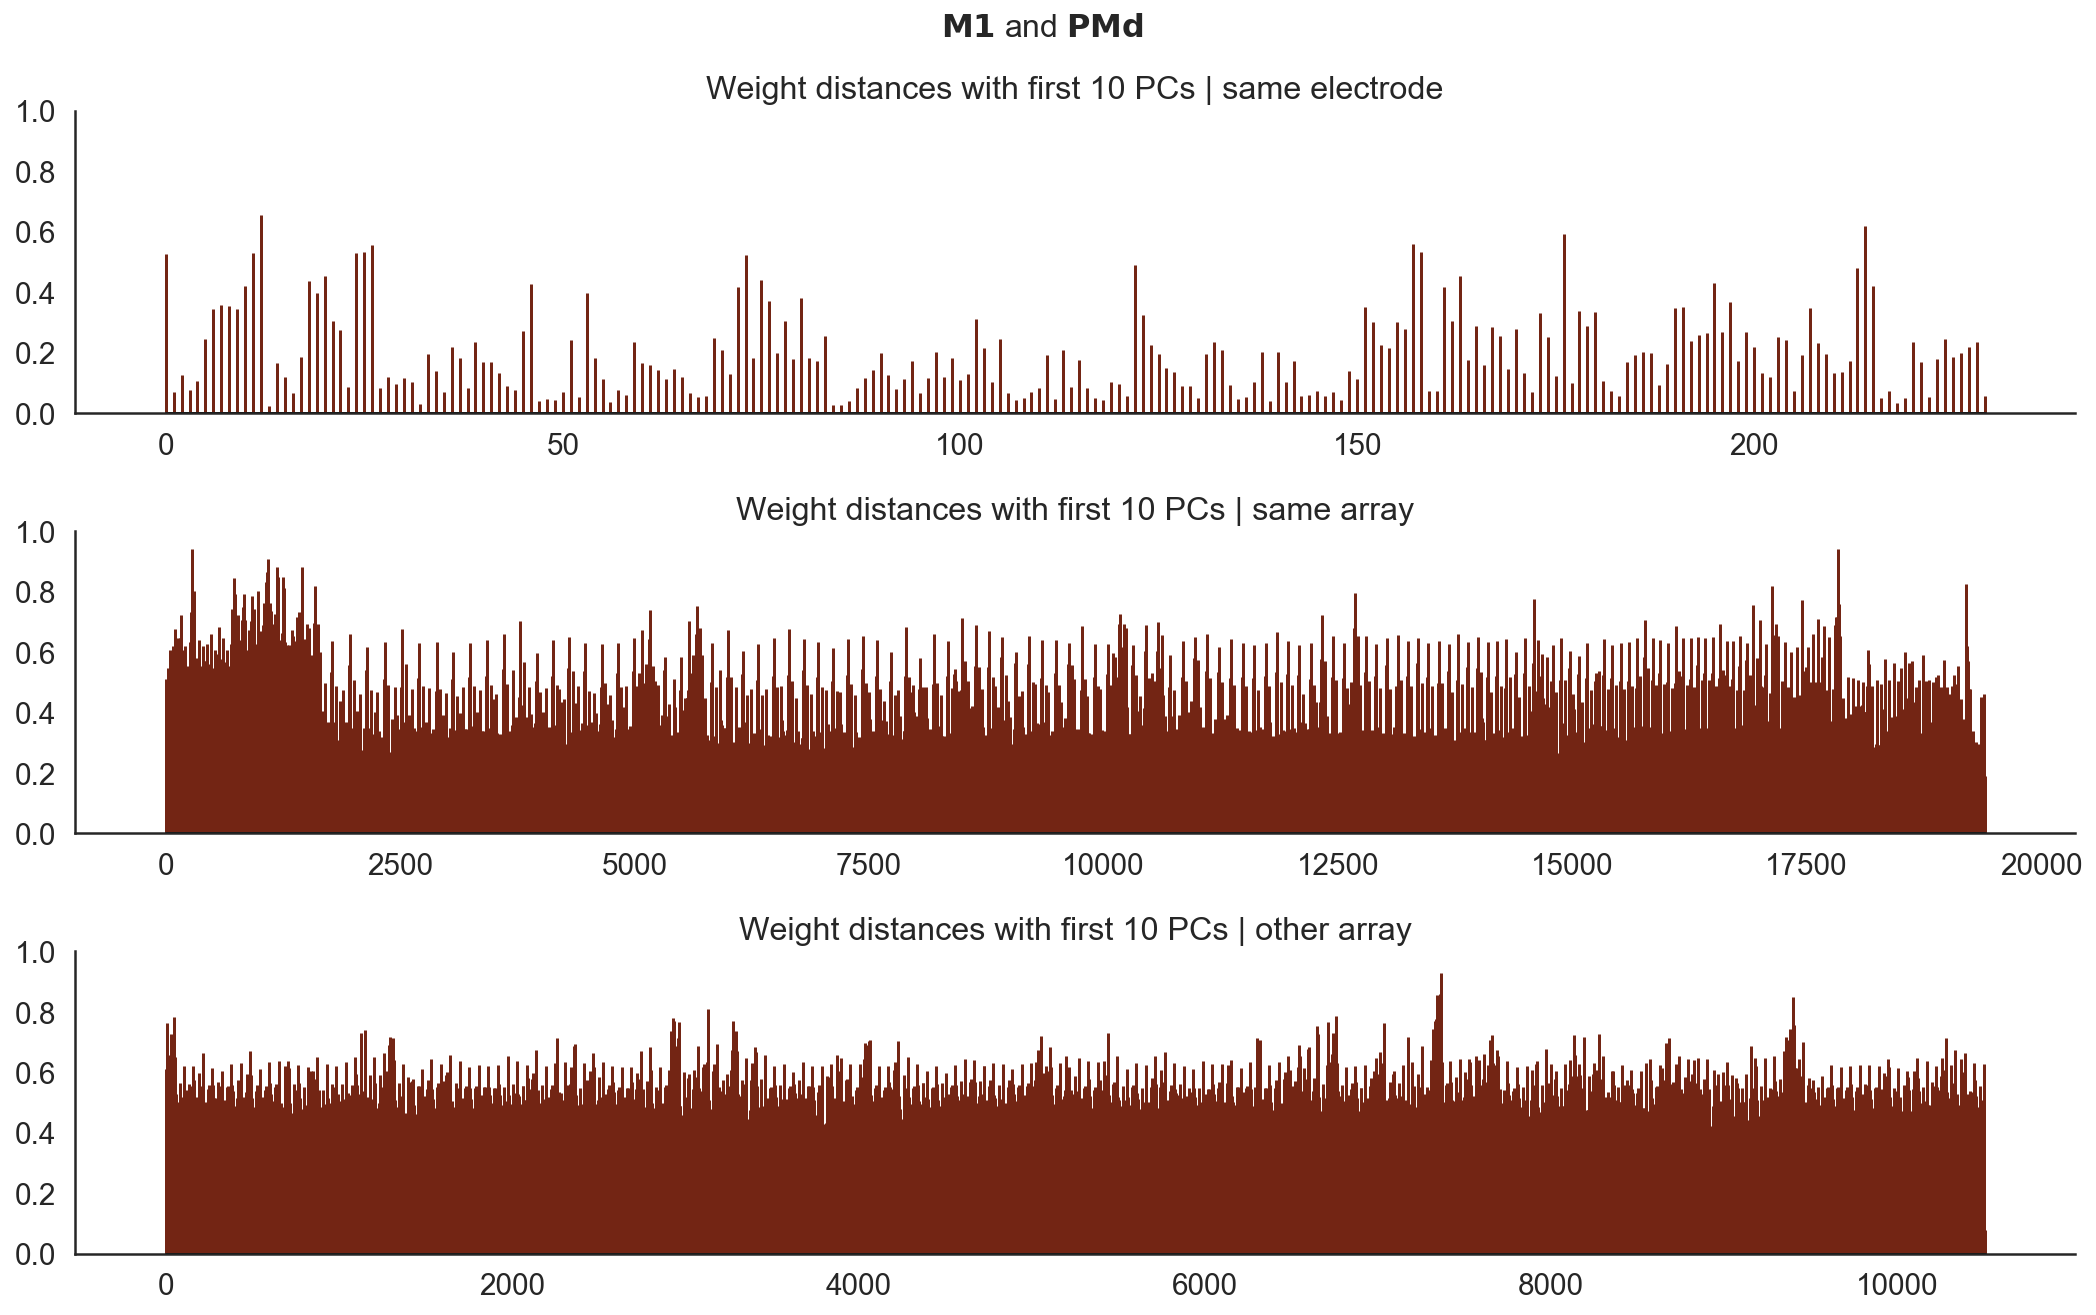

In [36]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 9))

fig.suptitle(r'$\bf{M1}$ and $\bf{PMd}$', y=1.02, fontsize=16)
axs[0].set_title(f'Weight distances with first {r} PCs | same electrode')
axs[0].stem(W_dist_se, basefmt='k-', markerfmt=' ', use_line_collection=True)
axs[0].set_ylim([0, 1])

axs[1].set_title(f'Weight distances with first {r} PCs | same array')
axs[1].stem(W_dist_sa, basefmt='k-', markerfmt=' ', use_line_collection=True)
axs[1].set_ylim([0, 1])

axs[2].set_title(f'Weight distances with first {r} PCs | other array')
axs[2].stem(W_dist_oa, basefmt='k-', markerfmt=' ', use_line_collection=True)
axs[2].set_ylim([0, 1])

sns.despine(), plt.tight_layout();

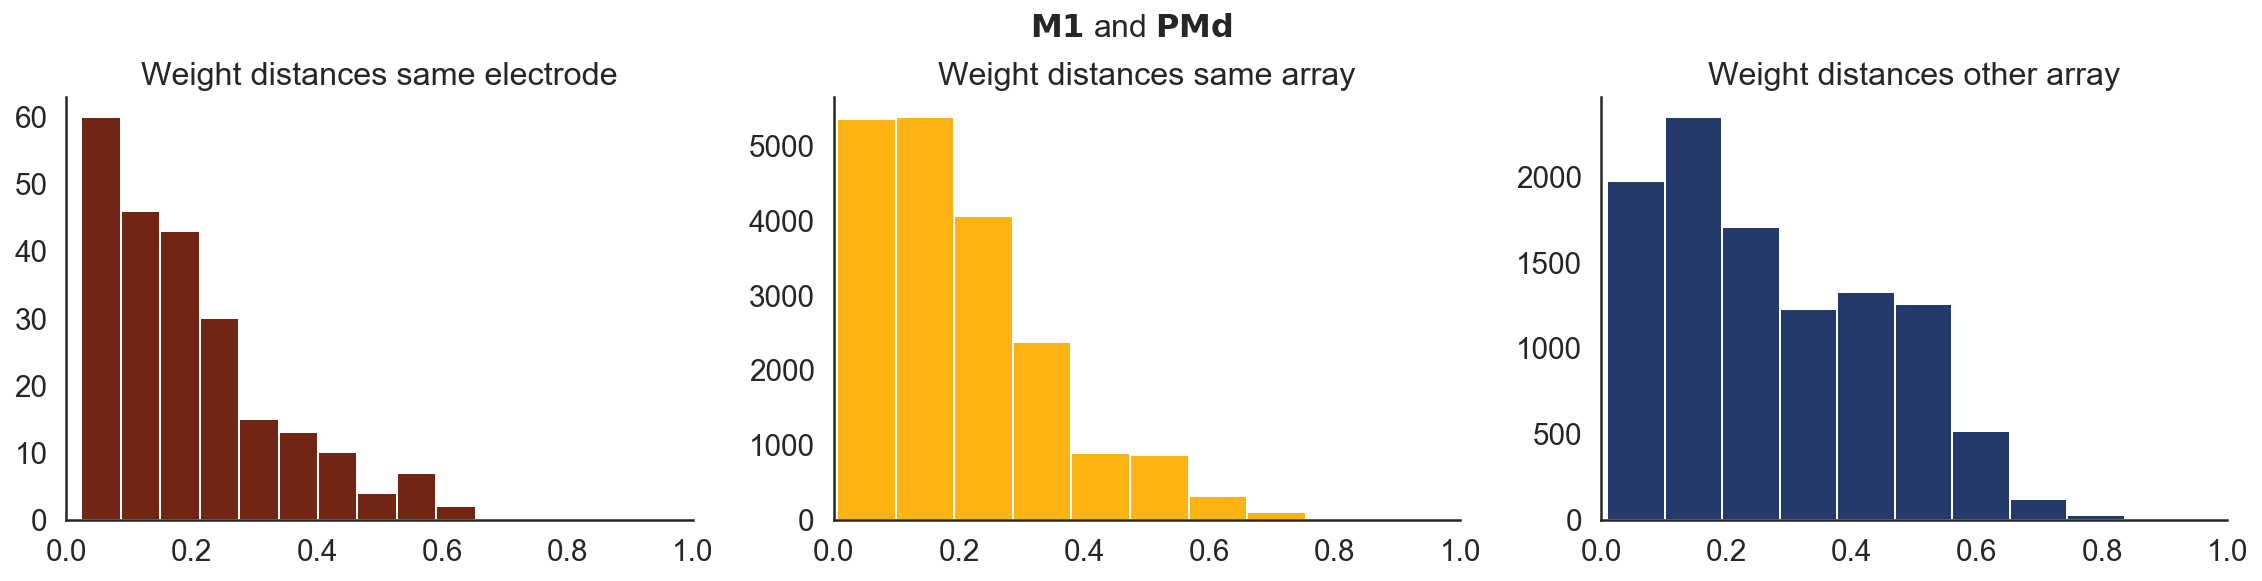

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.suptitle(r'$\bf{M1}$ and $\bf{PMd}$', y=1.02, fontsize=16)
axs[0].set_title('Weight distances same electrode')
axs[0].hist(W_dist_se, color=cs[0])
axs[0].set_xlim([0, 1])

axs[1].set_title('Weight distances same array')
axs[1].hist(W_dist_sa, color=cs[1])
axs[1].set_xlim([0, 1])

axs[2].set_title('Weight distances other array')
axs[2].hist(W_dist_oa, color=cs[2])
axs[2].set_xlim([0, 1])
sns.despine(), plt.tight_layout();

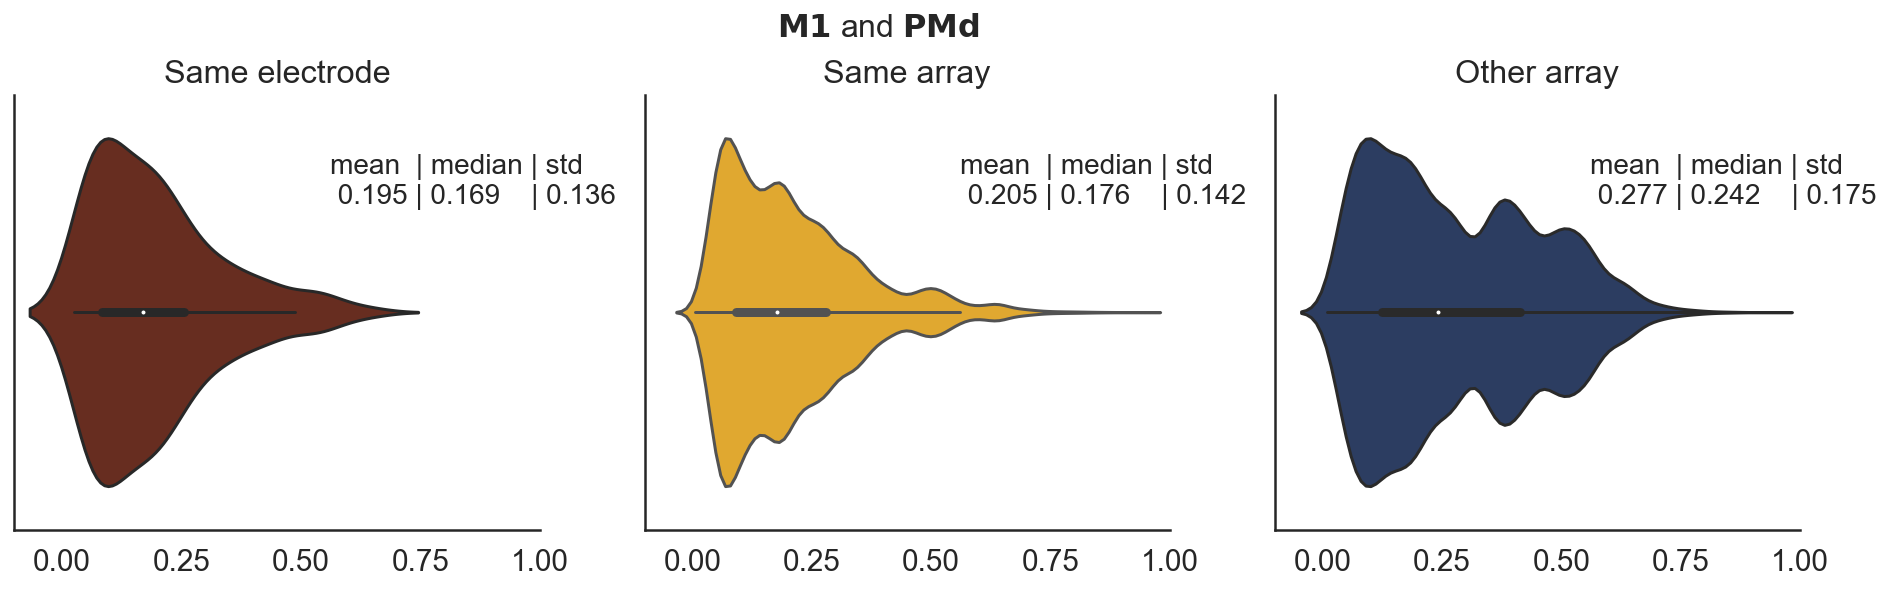

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

fig.suptitle(r'$\bf{M1}$ and $\bf{PMd}$', y=1.02, fontsize=16)
axs[0].set_title('Same electrode')
sns.violinplot(W_dist_se, color=cs[0], ax=axs[0])
axs[0].set_xlim([-0.1, 1])

axs[1].set_title('Same array')
sns.violinplot(W_dist_sa, color=cs[1], ax=axs[1])
axs[1].set_xlim([-0.1, 1])

axs[2].set_title('Other array')
sns.violinplot(W_dist_oa, color=cs[2], ax=axs[2])
axs[2].set_xlim([-0.1, 1])

axs[0].annotate(f'mean  | median | std \n {np.mean(W_dist_se):0.3f} | {np.median(W_dist_se):0.3f}    | {np.std(W_dist_se):0.3f}', xy=(0.6, 0.75), xycoords=axs[0].transAxes, fontsize=14)
axs[1].annotate(f'mean  | median | std \n {np.mean(W_dist_sa):0.3f} | {np.median(W_dist_sa):0.3f}    | {np.std(W_dist_sa):0.3f}', xy=(0.6, 0.75), xycoords=axs[1].transAxes, fontsize=14)
axs[2].annotate(f'mean  | median | std \n {np.mean(W_dist_oa):0.3f} | {np.median(W_dist_oa):0.3f}    | {np.std(W_dist_oa):0.3f}', xy=(0.6, 0.75), xycoords=axs[2].transAxes, fontsize=14)

sns.despine()

In [20]:
# Note that most samples have the within array distance, very few 'same electrode' ones
W_dist_se.shape, W_dist_sa.shape, W_dist_oa.shape

((230,), (19400,), (10505,))

In [251]:
def standardized_hist(W_dist_se, W_dist_sa, W_dist_oa, r, dividesqrt=False, plot_separate=False):
    ''' Plots the different groups through dividing all entries of a group by the max value in that group.
    
    Parameters
    ----------
    W_dist_se, W_dist_sa, W_dist_oa: np.array
        Weight distances by groups
    r: int
        Number of PCs
    '''
    binz = np.arange(0, 1, 0.01)
    xbar = [f'{b:.2f}' for b in binz]
    intvals = np.append(binz, np.inf)
    
    # KS tests
    p_se_sa, _ = ks_2samp(W_dist_se, W_dist_sa, alternative='less', mode='auto')
    p_se_oa, _ = ks_2samp(W_dist_se, W_dist_oa, alternative='less', mode='auto')
    p_sa_oa, _ = ks_2samp(W_dist_sa, W_dist_oa, alternative='less', mode='auto')

    fig, ax = plt.subplots(1, figsize=(12, 5))
    fig.suptitle(f'Weight distances with the highest {r} PCs', fontsize=15)

    # Compute all bins
    oa_bins = [np.sum((W_dist_oa >= intvals[i]) & (W_dist_oa < intvals[i + 1])) for i in range(len(binz))]
    oa_bins = oa_bins / max(oa_bins) * -1 # flip to the other side for visualization purposes

    sa_bins = [np.sum((W_dist_sa >= intvals[i]) & (W_dist_sa < intvals[i + 1])) for i in range(len(binz))]
    sa_bins = sa_bins / max(sa_bins)

    se_bins = [np.sum((W_dist_se >= intvals[i]) & (W_dist_se < intvals[i + 1])) for i in range(len(binz))]
    se_bins = se_bins / max(se_bins) 
    
    if dividesqrt:
        W_dist_se = W_dist_se * 1/np.sqrt(len(W_dist_se))
        W_dist_sa = W_dist_sa * 1/np.sqrt(len(W_dist_sa))
        W_dist_oa = W_dist_oa * 1/np.sqrt(len(W_dist_oa))

    # Plot 
    ax.bar(x=xbar, height=oa_bins, label='Other array', alpha=0.9, color=cs[2])
    ax.bar(x=xbar, height=sa_bins, label='Same array',   alpha=0.9, color=cs[1])
    ax.bar(x=xbar, height=se_bins, label='Same electrode', alpha=0.9, color=cs[0])

    ax.set_xlabel(r'$w_{dist}$')
    ax.set_xticks([f'{i/10:.2f}' for i in range(10)])
    ax.annotate(f'Same elec to same array | p={p_se_sa:.3f}', xy=(0.8, 0.9), xycoords=ax.transAxes)
    ax.annotate(f'Same elec to other array  | p={p_se_oa:.3f}', xy=(0.8, 0.8), xycoords=ax.transAxes)
    ax.annotate(f'Same array to other array | p={p_sa_oa:.3f}', xy=(0.8, 0.7), xycoords=ax.transAxes)
    ax.legend(loc='center right', bbox_to_anchor=(1, 0.2))
    sns.despine()
    plt.show();

    if plot_separate:

        fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

        axs[0].bar(x=xbar, height=oa_bins*-1, label='Other array', color=cs[2])
        axs[0].set_xticks([])

        axs[1].bar(x=xbar, height=sa_bins, label='Same array', alpha=1, color=cs[1])
        axs[1].set_xticks([])

        axs[2].bar(x=xbar, height=se_bins,  label='Same electrode', alpha=1, color=cs[0])
        axs[2].set_xticks([f'{i/10:.2f}' for i in range(10)])

        sns.despine()
        plt.show();

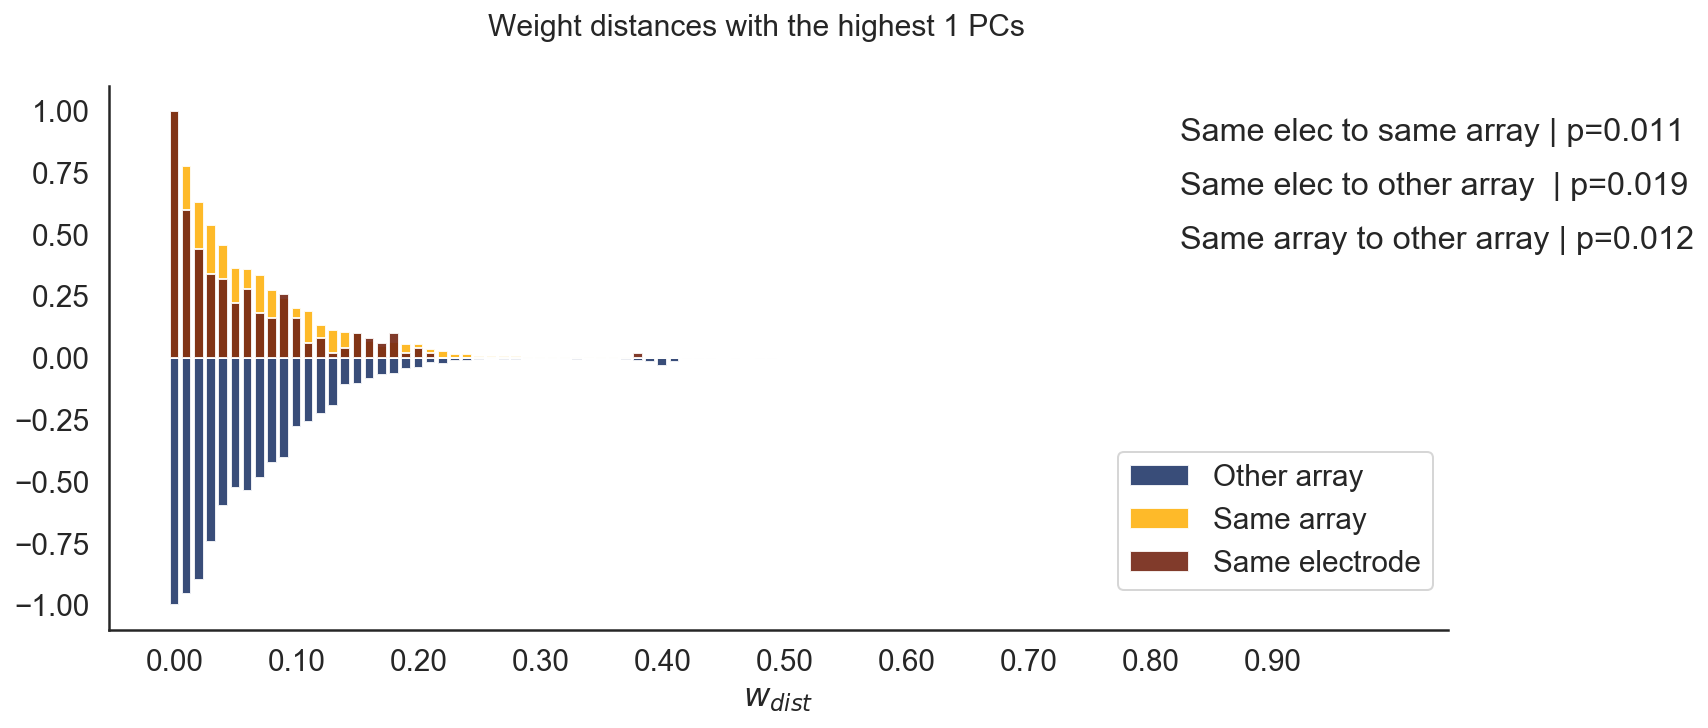

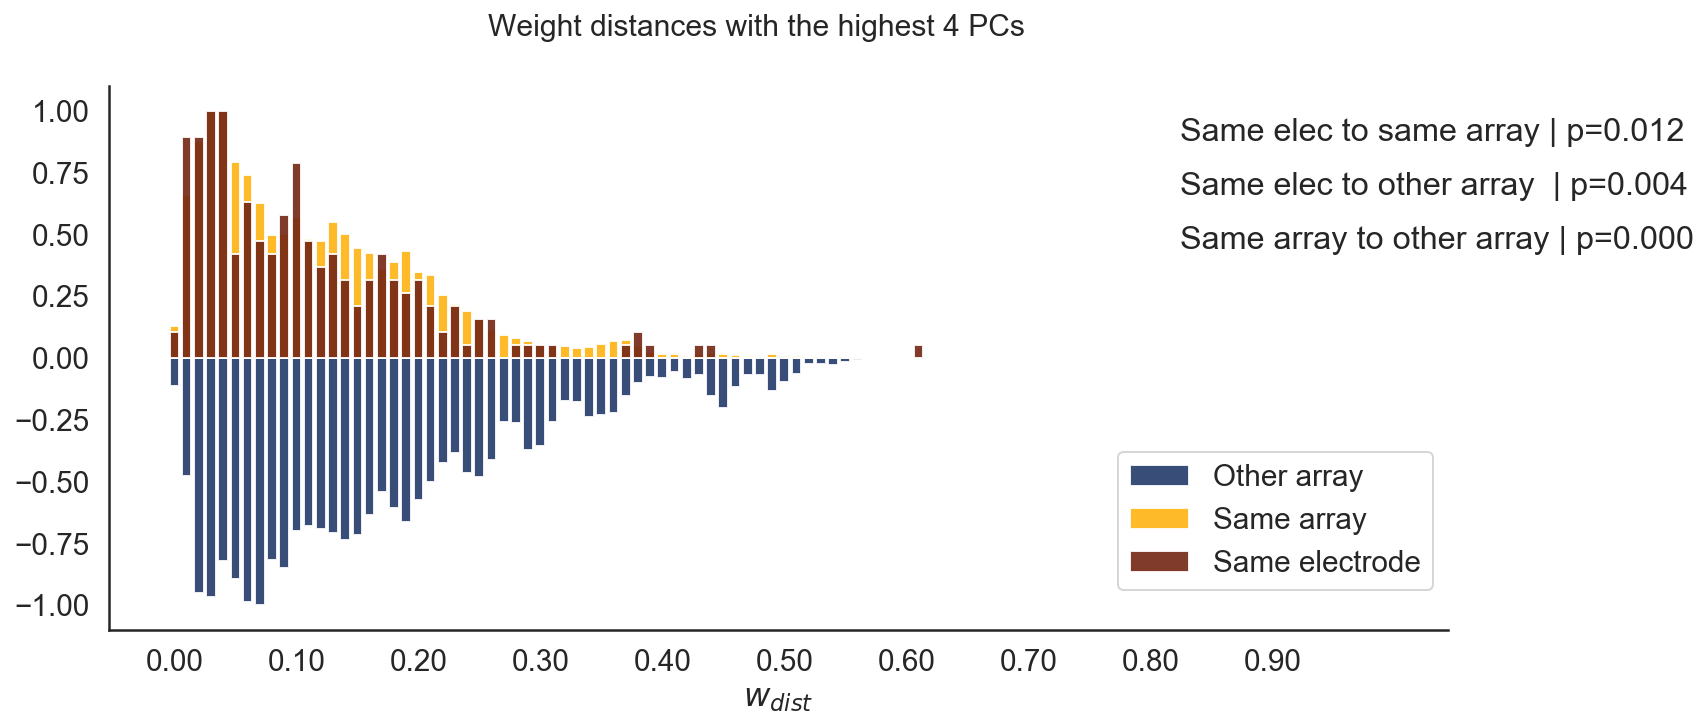

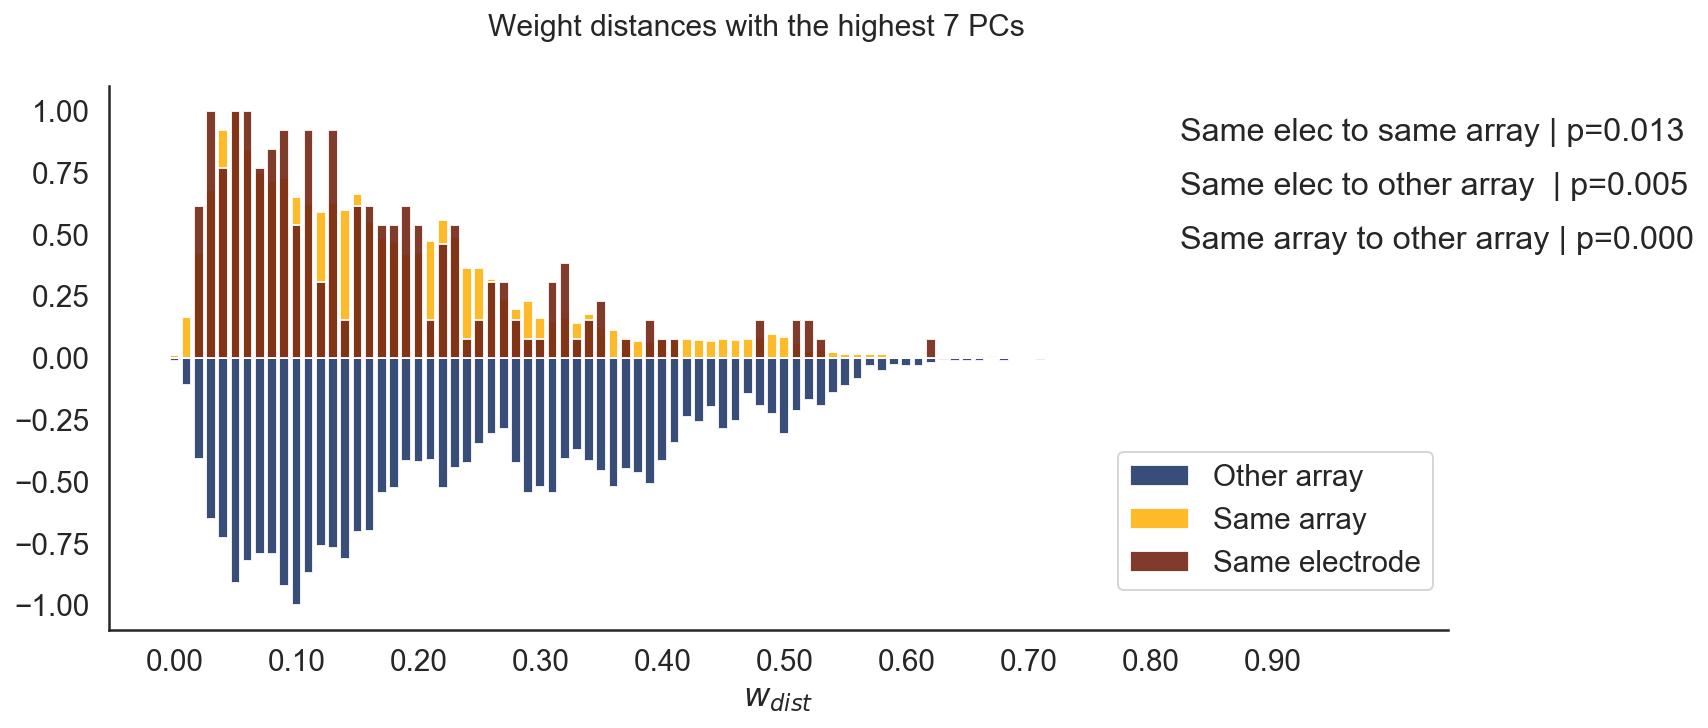

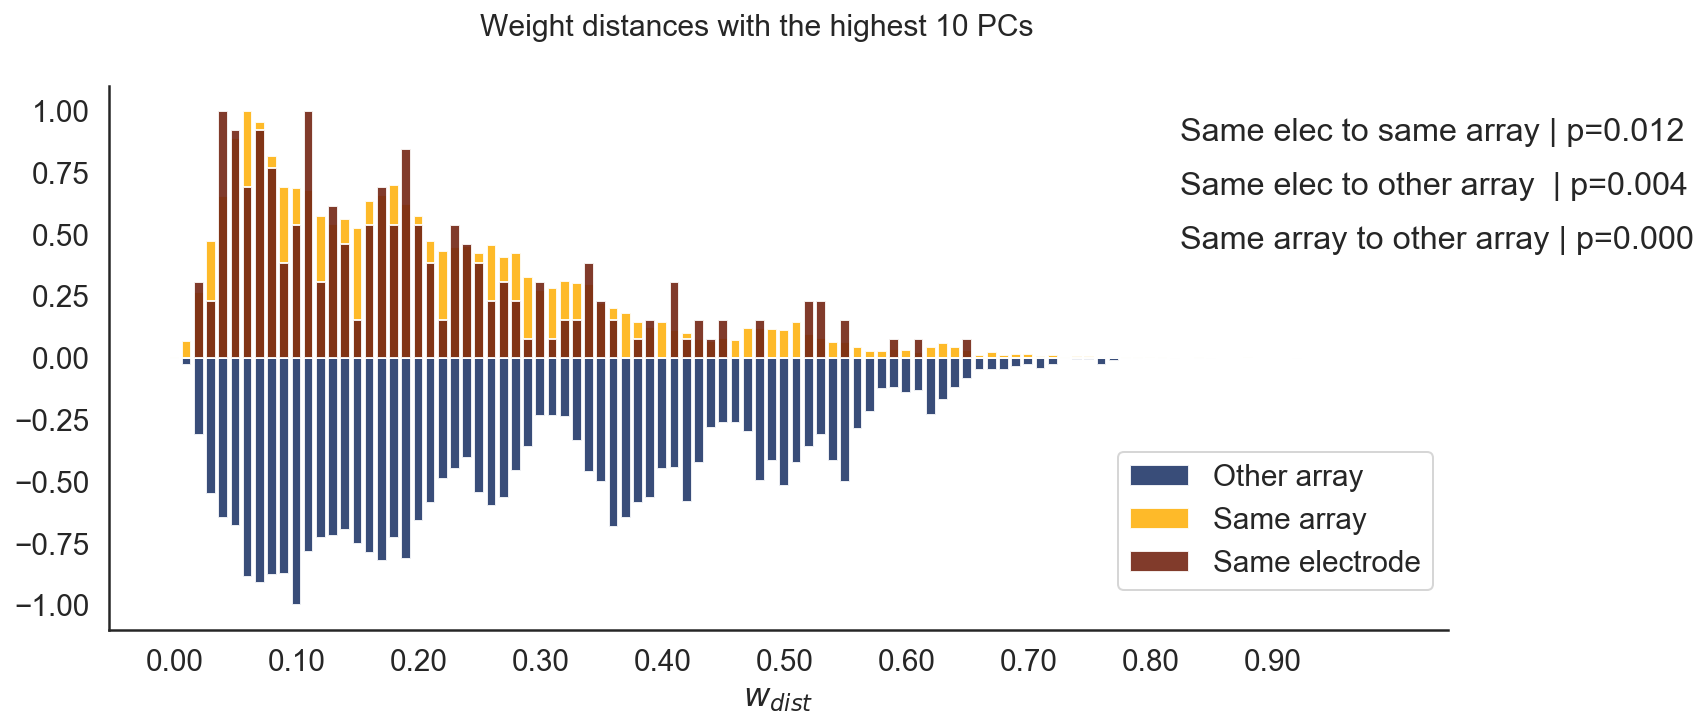

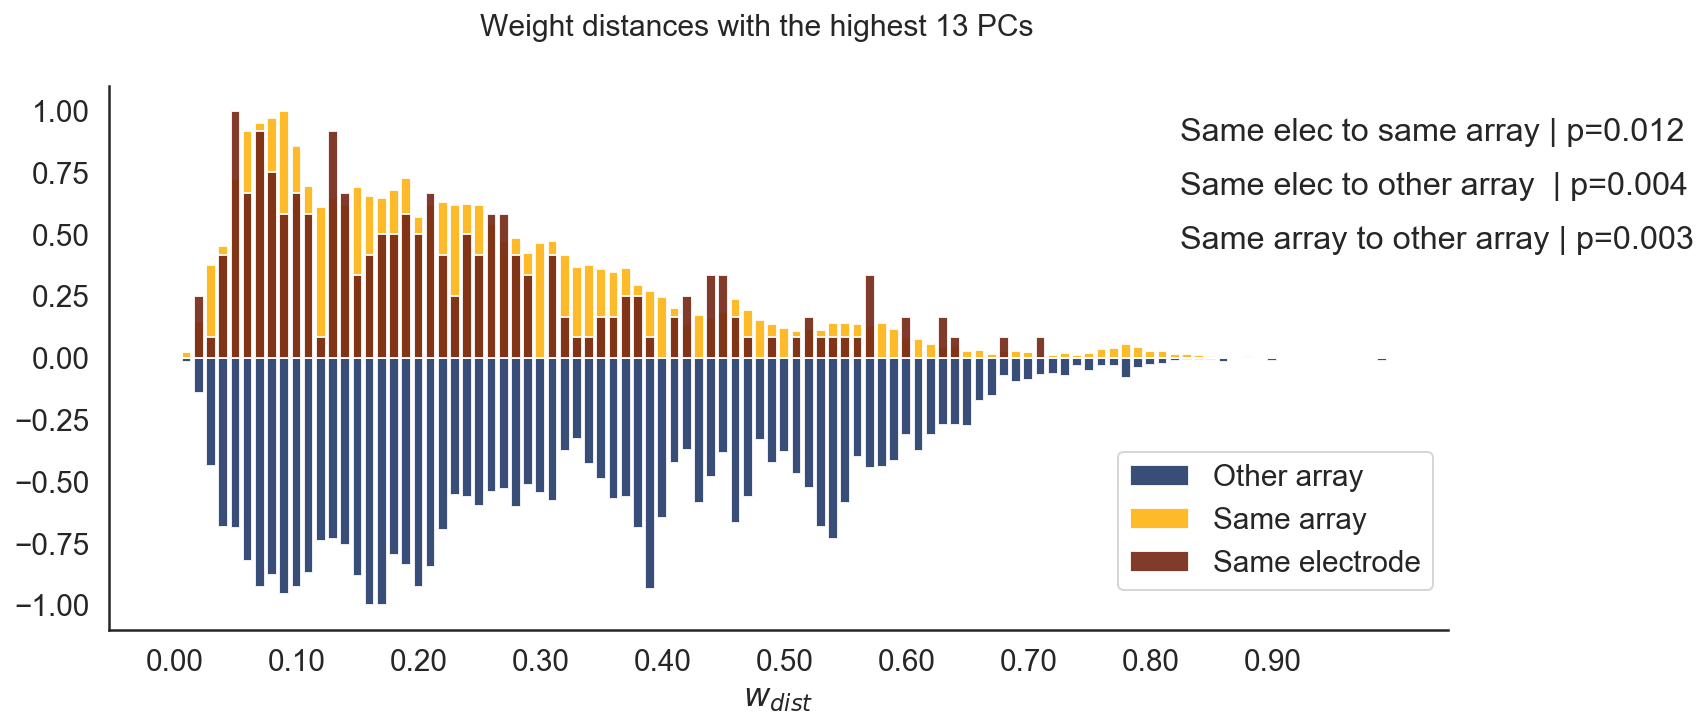

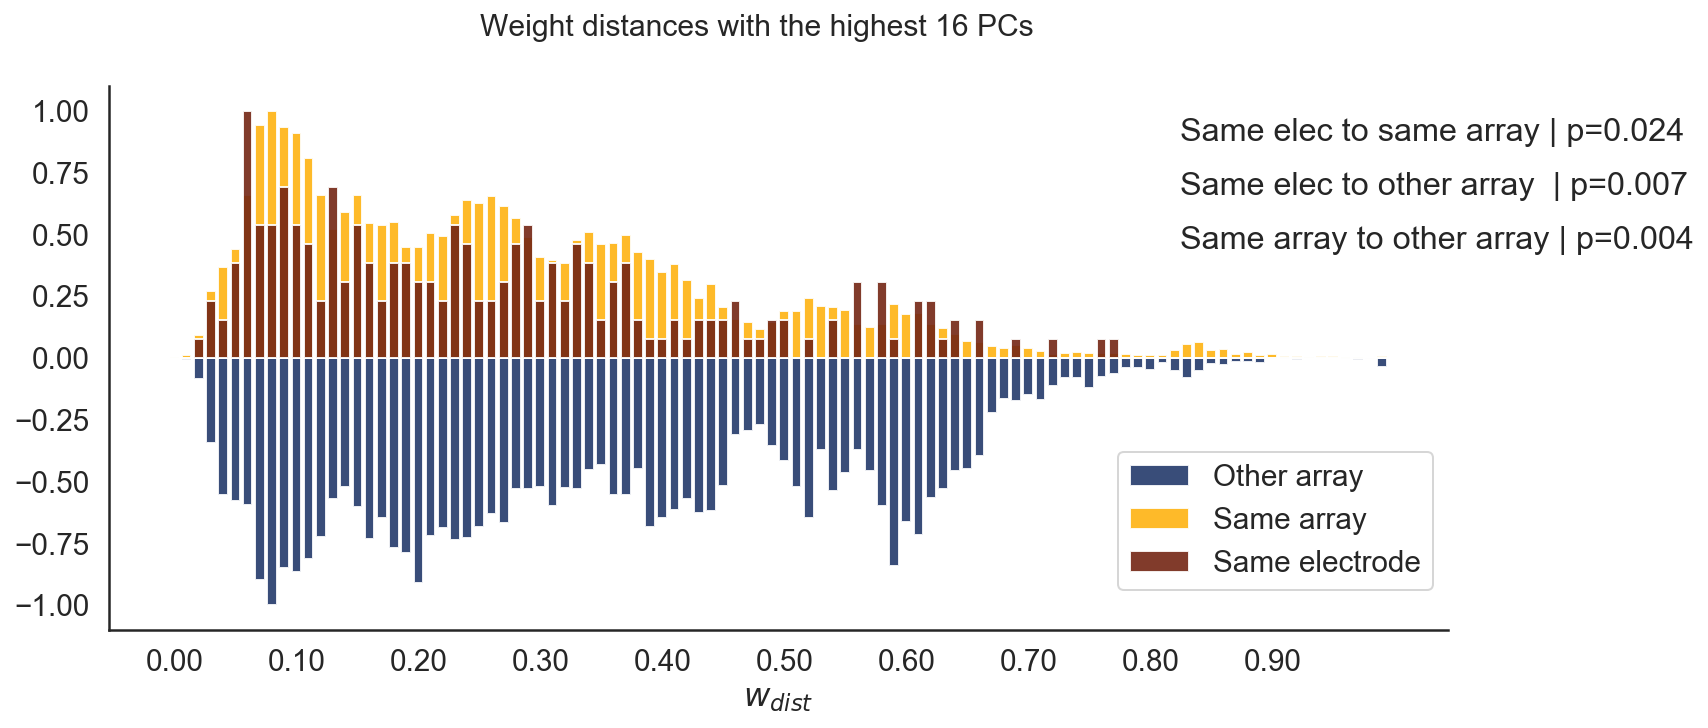

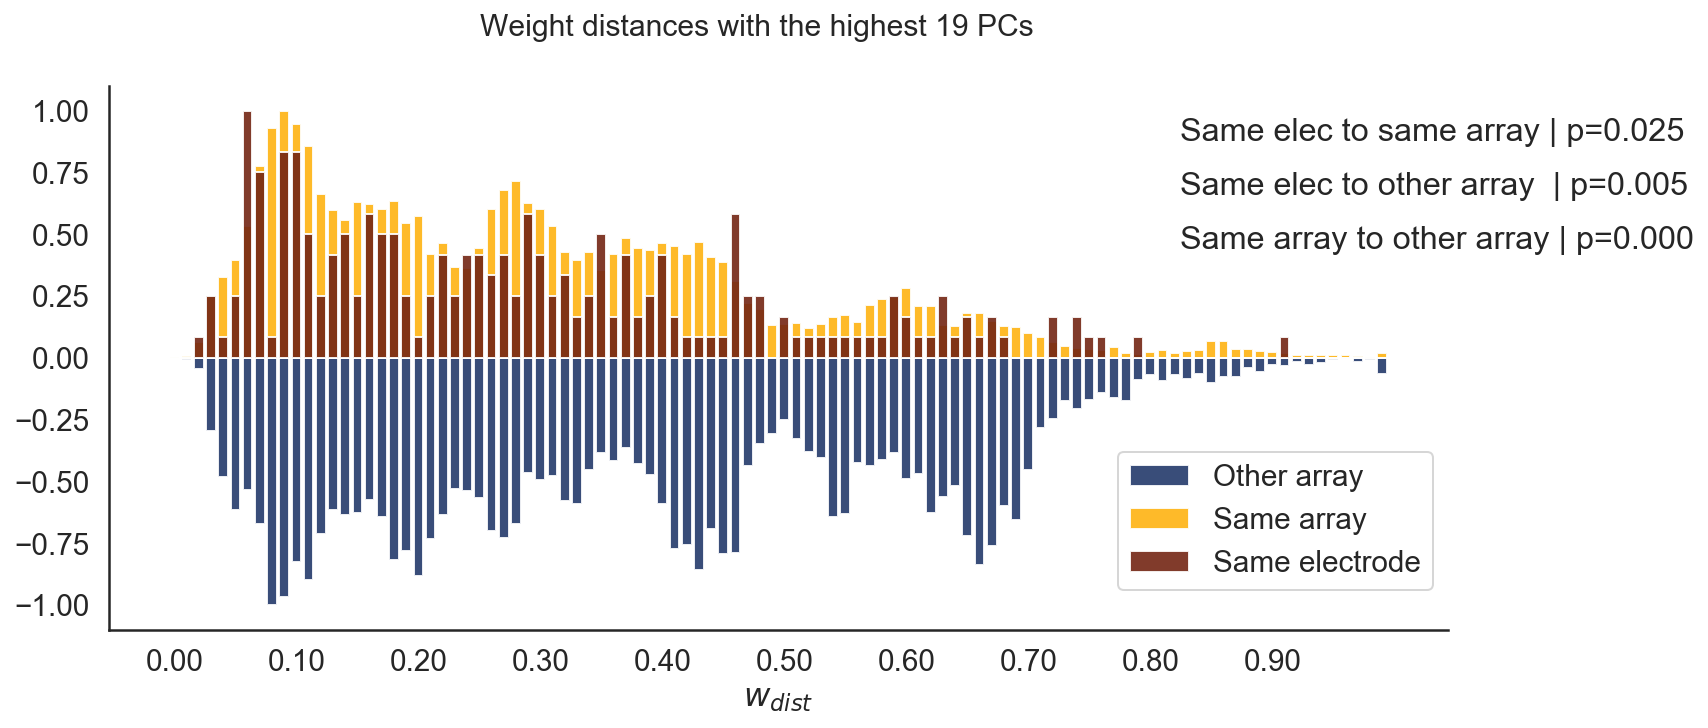

In [252]:
'''
Compute weight distance distributions for range of PCs 
'''

for r in np.arange(1, 20, 3):
    
    # Compute the spatial and weight distances with the first r PCs
    S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd, W_dist_oa = compare_r_pcs(pcs=m1pmd_pcs, r=r, m1_emap=m1_elecmap, m1_unitguide=td['M1_unit_guide'][0], 
                                                                            pmd_emap=pmd_elecmap, pmd_unitguide=td['PMd_unit_guide'][0])
    # Make groups within array based on spatial distance (same elec, same array)
    _ , W_dist_se, W_dist_sa = make_groups(S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd)
    
    # Make distribution
    standardized_hist(W_dist_se, W_dist_sa, W_dist_oa, r)

The $\ell_2$-norm of a vector $\mathbf{w} \in \mathbb{R}^n$ is given by
\begin{align*}
    \sqrt{\sum_{i=1}^n w_{i}^{2}}.
\end{align*}
We want to compare the $\ell_2$-norms of vectors of different lengths. Without loss of generality, we may assume the vectors are given by $\mathbf{w} \in \mathbb{R}^n$ and $v\in\mathbb{R}^m$ for $n \neq m$. We propose dividing the sum in the distances by $\sqrt{n}$ to obtain:
\begin{align*}
    \sqrt{\frac{1}{n}\sum_{i=1}^n w_{i}^{2}}.
\end{align*}

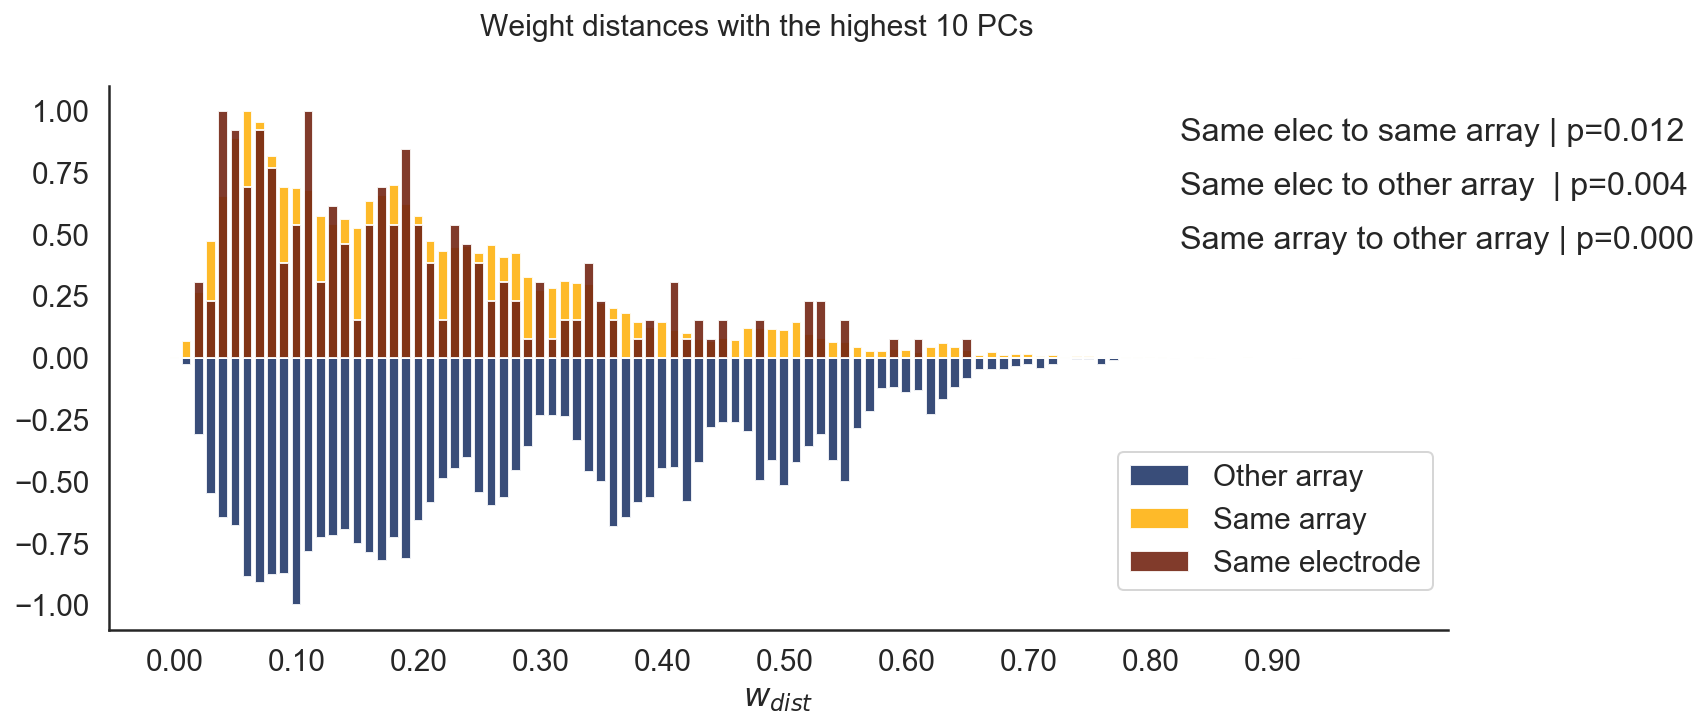

In [253]:
# Compute the spatial and weight distances with the first r PCs
S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd, W_dist_oa = compare_r_pcs(pcs=m1pmd_pcs, r=10, m1_emap=m1_elecmap, m1_unitguide=td['M1_unit_guide'][0], 
                                                                        pmd_emap=pmd_elecmap, pmd_unitguide=td['PMd_unit_guide'][0])
# Make groups within array based on spatial distance (same elec, same array)
_ , W_dist_se, W_dist_sa = make_groups(S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd)

# Make distribution
standardized_hist(W_dist_se, W_dist_sa, W_dist_oa, r=10, dividesqrt=True)

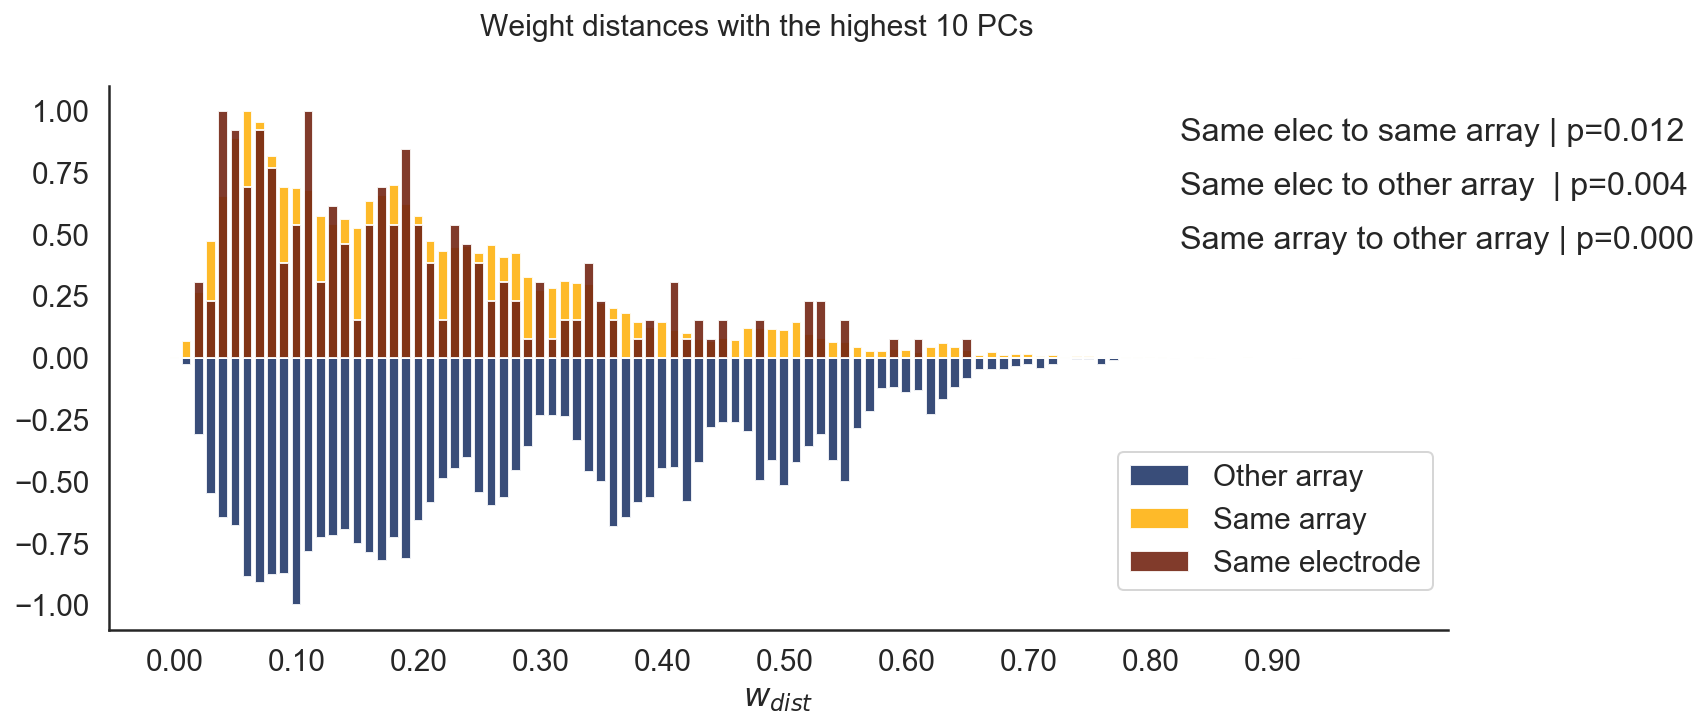

In [254]:
standardized_hist(W_dist_se, W_dist_sa, W_dist_oa, r=10, dividesqrt=False)

### Take one neuron and compare to all other neurons

How can we observe what happens to the weight differences as we incease _r_?

One thing to do is to choose one neuron and plot the weight distance over _r_.


In [160]:
m1_emap = m1_elecmap
m1_unitguide = td.M1_unit_guide[0]

In [163]:
n_m1 = m1_unitguide.shape[0] # Number of neurons on m1
R = 246 # PCs 

m1_within_S_dist = np.zeros(n_m1) # each row are the weight difference with r = 1, 2, ... PCs
m1_within_W_dist = np.zeros((R, n_m1))
r_range = np.arange(0, R, 1)

i = 0 # Fix one neuron
elec_i = m1_unitguide[i, 0] # Neuron is on this electrode
loc_i  = np.asarray(np.where(m1_emap == elec_i)) # Location of electrode on array

for idx, r in enumerate(r_range):
    
    M = m1pmd_pcs[:, :r] # Take first r PCs
    
    # Compare this neuron's weights (row) to all other neurons within array (j != i)
    for j in range(i, n_m1):
        
        elec_j = m1_unitguide[j, 0]
        loc_j  = np.asarray(np.where(m1_emap == elec_j))

        # Get distance between two neurons on array
        m1_within_S_dist[j] = LA.norm(loc_i - loc_j)
        
        # Compute PC weight distance between the neurons
        m1_within_W_dist[r, j] = LA.norm(M[i, :] - M[j, :])   

In [194]:
m1_within_W_dist.shape # R x neurons

(246, 55)

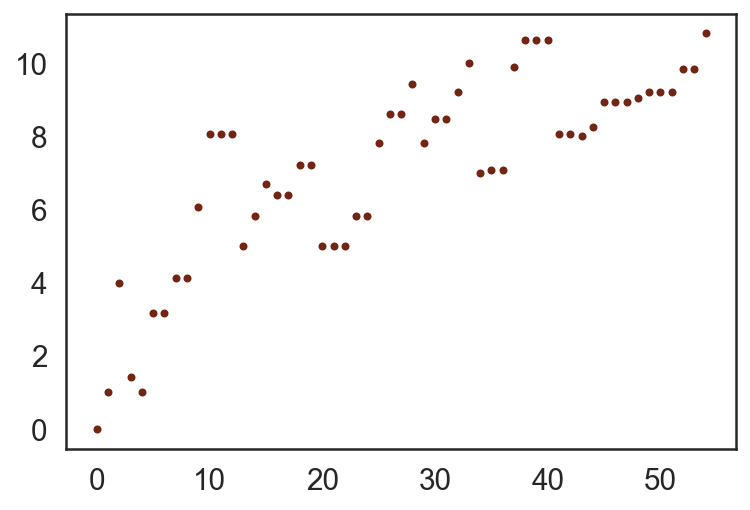

In [233]:
plt.plot(m1_within_S_dist, '.');

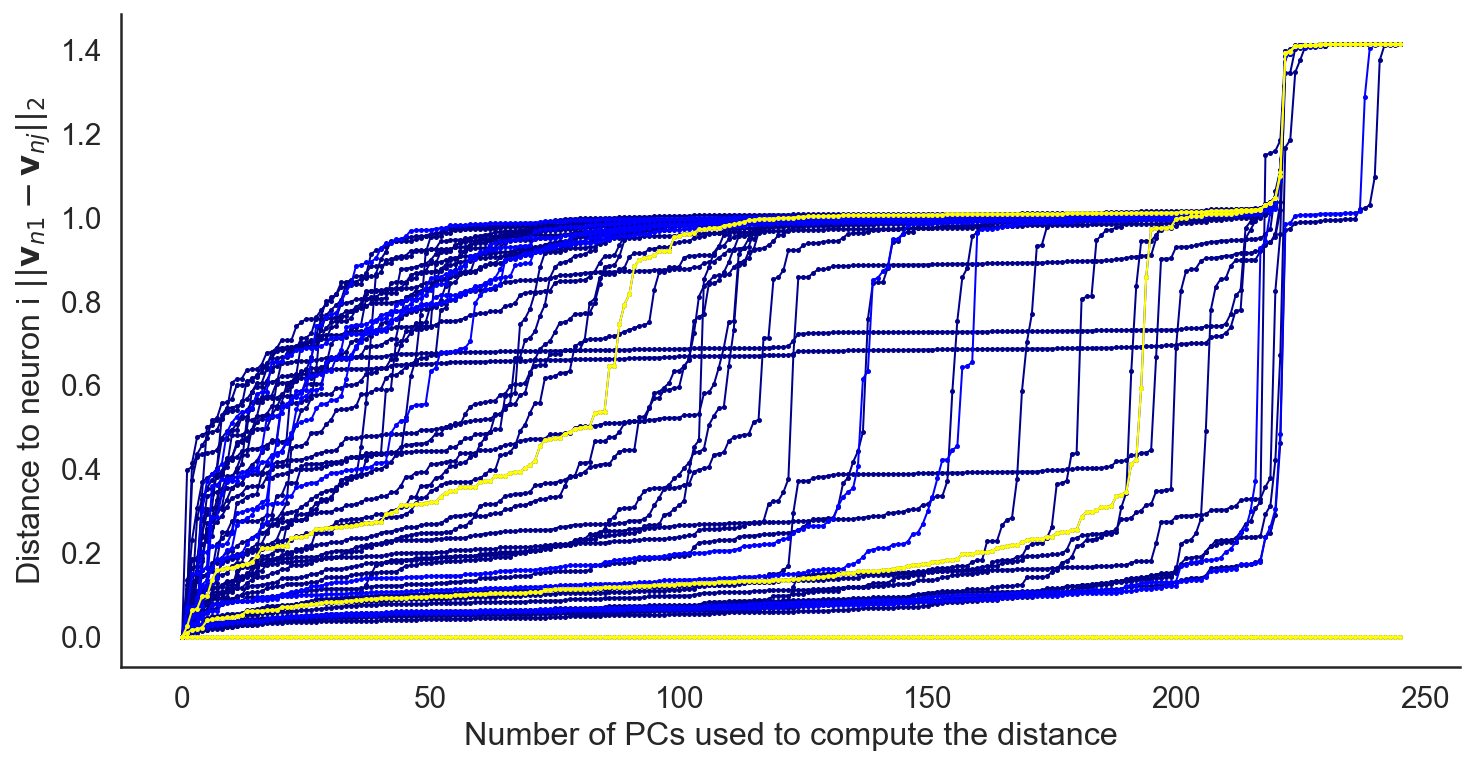

In [244]:
# Group by spatial distance
mask_1 = np.where(m1_within_S_dist <= 1)[0]
mask_5 = np.where(m1_within_S_dist <= 5)[0]
mask_10 = np.where(m1_within_S_dist > 5)[0]

fig, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(r_range, m1_within_W_dist[:, mask_10], '.-', ms=3, lw=1, c='darkblue')
ax.plot(r_range, m1_within_W_dist[:, mask_5], '.-', ms=3, lw=1, c='b')
ax.plot(r_range, m1_within_W_dist[:, mask_1], '.-', ms=3, lw=1, c='yellow')
ax.set_title(f'')
ax.set_xlabel(f'Number of PCs used to compute the distance')
ax.set_ylabel(r'Distance to neuron i $|| \mathbf{v}_{n1} - \mathbf{v}_{nj} ||_2$')
sns.despine()

However, this method does not really scale. In order to find out how the distances change over $r$ PCs we need to compute averages.

### 3.3 Compare PCs of one neuron to _k_ other neurons for range of _r_ values

---

> How does the weight distance evolve as we take more PCs to compute the weight distances?


`for r in range(R):`

- Take first `r` PCs (cols)
- Compute distances between each combination of neurons (rows)
- Make categories based on distance (se, sa, oa)
- Compute averages within categories over `r` PCs
- Plot the mean, median and stds for all 3 categories

In [171]:
R = 246

# Want to track the mean, median and std as r changes
stats_same_elec = np.zeros((3, R)) 
stats_same_arr  = np.zeros((3, R)) 
stats_other_arr = np.zeros((3, R)) 

for i in range(R):
    
    r = i + 1
    
    # Compute the spatial and weight distances with the first r PCs
    S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd, W_dist_oa = compare_r_pcs(pcs=m1pmd_pcs, r=r, m1_emap=m1_elecmap, m1_unitguide=td['M1_unit_guide'][0], 
                                                                            pmd_emap=pmd_elecmap, pmd_unitguide=td['PMd_unit_guide'][0])
    # Make groups within array based on spatial distance (same elec, same array)
    _ , W_dist_se, W_dist_sa = make_groups(S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd)
    
    # Compute statistics in each group and store
    stats_same_elec[0, i] = np.mean(W_dist_se) 
    stats_same_elec[1, i] = np.median(W_dist_se) 
    stats_same_elec[2, i] = np.std(W_dist_se) 
    
    stats_same_arr[0, i] = np.mean(W_dist_sa) 
    stats_same_arr[1, i] = np.median(W_dist_sa) 
    stats_same_arr[2, i] = np.std(W_dist_sa) 
    
    stats_other_arr[0, i] = np.mean(W_dist_oa) 
    stats_other_arr[1, i] = np.median(W_dist_oa) 
    stats_other_arr[2, i] = np.std(W_dist_oa) 

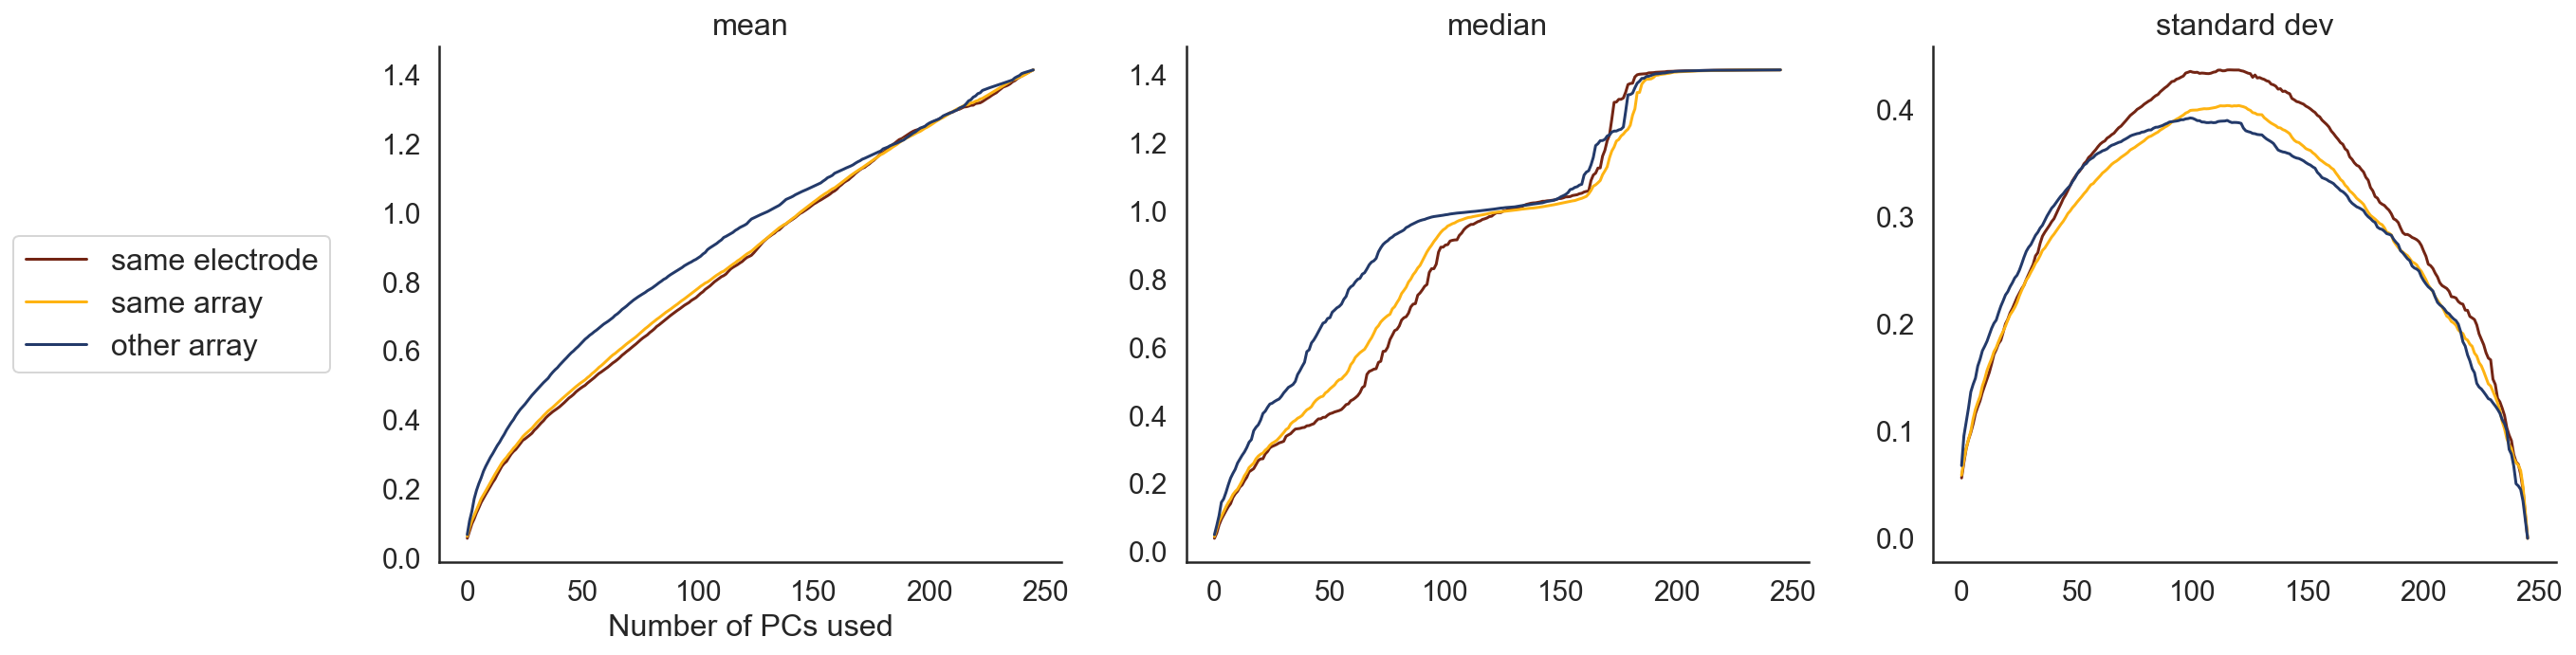

In [172]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharex=True)

# Plot all the means
axs[0].set_title('mean')
axs[0].plot(stats_same_elec[0, :], label='same electrode')
axs[0].plot(stats_same_arr[0, :],  label='same array')
axs[0].plot(stats_other_arr[0, :], label='other array')
axs[0].set_xlabel('Number of PCs used')

# Plot all the medians
axs[1].set_title('median')
axs[1].plot(stats_same_elec[1, :])
axs[1].plot(stats_same_arr[1, :])
axs[1].plot(stats_other_arr[1, :])

# Plot all the standard deviations
axs[2].set_title('standard dev')
axs[2].plot(stats_same_elec[2, :])
axs[2].plot(stats_same_arr[2, :])
axs[2].plot(stats_other_arr[2, :])

axs[0].legend(loc='center right', bbox_to_anchor=(-0.15, 0.5), fontsize=16)
sns.despine()

#### Interpretation

We perform trial-concatenated PCA, which produces a separate set of temporal factors for each trial. Concretely, let $\mathbf{X}$ be our data matrix of size _N_ $\times$ _T_ ()

\begin{align}
    \mathbf{X} = \mathbf{W} \mathbf{B}^\top 
\end{align}

where

- $\mathbf{W}$ is the _N_ $\times$ _N_ matrix with as columns the neuron factors (these are the **principal components / neural modes** that form a basis for the neural space)
- $\mathbf{B}$ is the _T_ $\times$ _T_ matrix with as columns the temporal factors (we have a set of these for each trial)


---

Therefore

- All 